In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
import matplotlib.pyplot as plt

In [ ]:
transform = Compose([
    ToTensor(),
    Normalize((0.5), (0.5)),
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

In [3]:
batch_size = 64
z_noise = 100

train_dataloader = DataLoader(training_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(torch.min(X), torch.max(X))
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
tensor(-1.) tensor(1.)


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        return x

discriminator = Discriminator().to(device)
print(discriminator)

Using cuda device
Discriminator(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Dropout(p=0.3, inplace=False)
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Dropout(p=0.3, inplace=False)
    (13): Linear(in_features=64, out_features=1, bias=True)
    (14): Sigmoid()
  )
)


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_noise, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        return x

generator = Generator().to(device)
print(generator)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=256, out_features=784, bias=True)
    (9): Tanh()
  )
)


In [6]:
loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4)

In [7]:
epoch = 50

for i in range(epoch):
  print(f"Epoch {i+1}\n-------------------------------")

  discriminator.train()
  generator.train()
  for batch, (img, _) in enumerate(train_dataloader):
    img = img.to(device)

    d_optimizer.zero_grad()

    noise = torch.randn(batch_size, z_noise).to(device)
    fake_img = generator(noise)
    fake_img = fake_img.reshape(-1, 1, 28, 28)
    d_real = discriminator(img)
    d_real_loss = loss_fn(d_real, torch.ones_like(d_real))

    d_fake = discriminator(fake_img)
    d_fake_loss = loss_fn(d_fake, torch.zeros_like(d_fake))

    d_loss = (d_real_loss + d_fake_loss) / 2

    d_real_loss.backward()
    d_fake_loss.backward()
    d_optimizer.step()


    g_optimizer.zero_grad()

    noise = torch.randn(batch_size, z_noise).to(device)
    fake_img = generator(noise)
    fake_img = fake_img.reshape(-1, 1, 28, 28)
    d_fake = discriminator(fake_img)
    d_fake_loss = loss_fn(d_fake, torch.ones_like(d_fake))

    d_fake_loss.backward()
    g_optimizer.step()

    # if batch % 100 == 0:
    #   print(f"D loss: {d_loss:>7f}", f"G loss: {d_fake_loss:>7f}")
  print(f"D loss: {d_loss:>7f}", f"G loss: {d_fake_loss:>7f}")
print("Done!")

Epoch 1
-------------------------------
D loss: 0.260119 G loss: 2.718976
Epoch 2
-------------------------------
D loss: 0.579600 G loss: 1.041501
Epoch 3
-------------------------------
D loss: 0.295326 G loss: 2.183293
Epoch 4
-------------------------------
D loss: 0.251046 G loss: 2.473740
Epoch 5
-------------------------------
D loss: 0.261866 G loss: 3.105808
Epoch 6
-------------------------------
D loss: 0.363876 G loss: 1.487155
Epoch 7
-------------------------------
D loss: 0.213070 G loss: 2.067913
Epoch 8
-------------------------------
D loss: 0.717558 G loss: 1.346119
Epoch 9
-------------------------------
D loss: 0.550211 G loss: 2.056139
Epoch 10
-------------------------------
D loss: 0.294704 G loss: 1.923156
Epoch 11
-------------------------------
D loss: 0.219515 G loss: 1.977690
Epoch 12
-------------------------------
D loss: 0.411090 G loss: 1.674067
Epoch 13
-------------------------------
D loss: 0.221404 G loss: 1.944442
Epoch 14
-------------------------

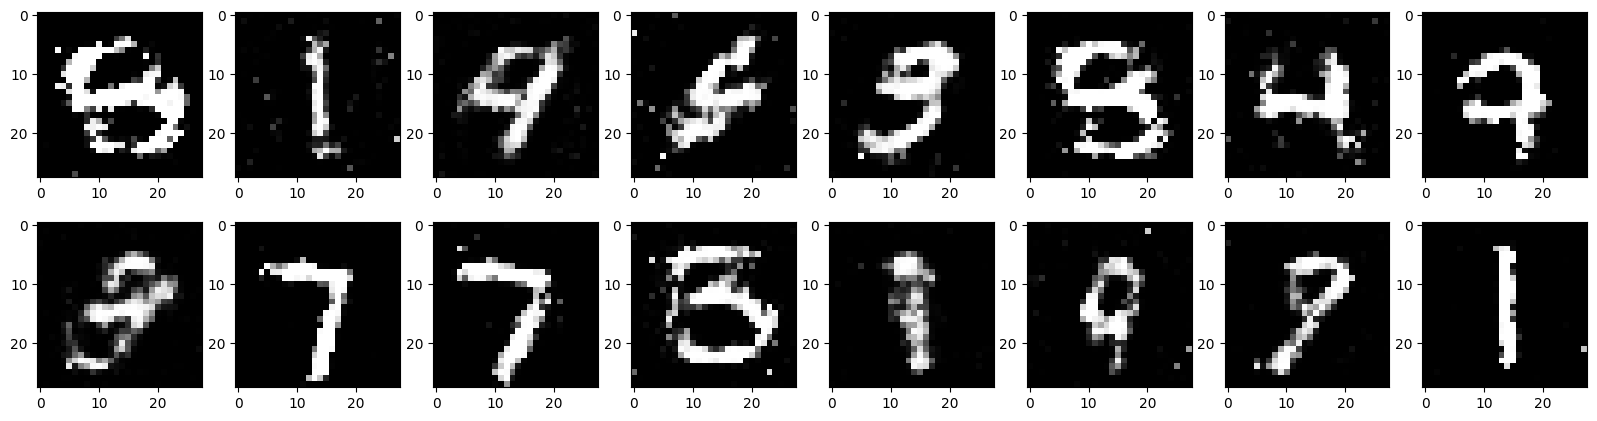

In [8]:
fig = plt.figure(figsize=(20, 5))
rows = 2
columns = 8
with torch.no_grad():
  for i in range(16):
    fig.add_subplot(rows, columns, i+1)
    noise = torch.randn(1, z_noise).to(device)
    fake_img = generator(noise).cpu().detach()
    fake_img = fake_img.reshape(-1,1,28,28)
    plt.imshow(fake_img[0][0].detach().numpy(), cmap="gray")